In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from scipy.stats import binned_statistic, powerlaw
from scipy.interpolate import interp1d
import kmeans_radec
from astropy.io import ascii
import Setup as p

import SelectionFunc

/mnt/zfsusers/rstiskalek/src/BMmatching/SelectionFunc.py:150: RuntimeWarning: overflow encountered in exp
  return -np.exp(a*x+b) + c*x + d
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
data = fits.open("../../BAM/a100springfull.fits")[1].data

# Unpack all the values
RA = data['RAdeg_HI']
DEC = data['DECdeg_HI']
dist = data['Dist']
logMH = data['logMH']
MS = data['SERSIC_MASS']
apmag = data['petroMag_r']

# Take only the ones with finite SM
IDS = np.where(np.isfinite(MS))
RA = RA[IDS]
DEC = DEC[IDS]
dist = dist[IDS]
logMH = logMH[IDS]
logMS = np.log10(MS[IDS])
apmag = apmag[IDS]

logMB = np.log10(10**logMS+1.4*10**logMH)

# # Choose sample size:
# fraction = 1.0
# Ntot = logMB.size
# size = int(Ntot*fraction)
# arr = np.arange(Ntot)
# IDS = np.random.choice(arr, size, False)

# logMB = logMB[IDS]
# RA = RA[IDS]
# DEC = DEC[IDS]
# dist = dist[IDS]
# logMH = logMH[IDS]
# logMS = logMS[IDS]
# apmag = apmag[IDS]

[9.214989409400577, 9.761642992088387, 10.044202522198823]
9322.0
7253.999999999999
5179.0


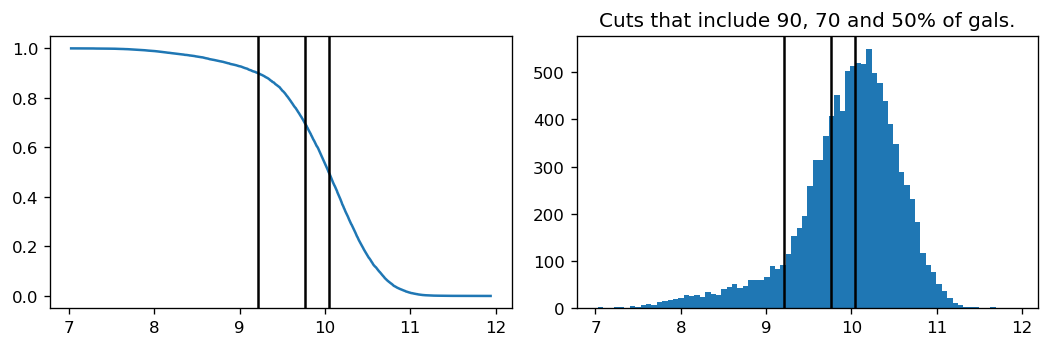

In [4]:
t = np.linspace(logMB.min(), logMB.max(),1000)

def func(masscut):
    return np.where(logMB>masscut)[0].size/logMB.size

y = interp1d(np.array([func(i) for i in t]), t)

perc_list = [0.90, 0.7, 0.50]
cuts = [float(y(i)) for i in perc_list]

cuts_def = {perc_list[0] : cuts[0],
           perc_list[1] : cuts[1],
           perc_list[2] : cuts[2]}

p.dump_pickle(cuts_def, "../../Data/BMmatching/logMBcuts_def.p")
print(cuts)



t = np.linspace(logMB.min(), logMB.max(),1000)
plt.figure(dpi=120, figsize=(9, 3))

plt.subplot(121)
plt.plot(t, [func(i) for i in t])
for c in cuts:
    plt.axvline(c, c='black')
    print(func(c)*logMB.size)


plt.subplot(122)
plt.hist(logMB, bins='auto')
plt.title("Cuts that include 90, 70 and 50% of gals.")
for c in cuts:
    plt.axvline(c, c='black')

plt.tight_layout()
plt.show()



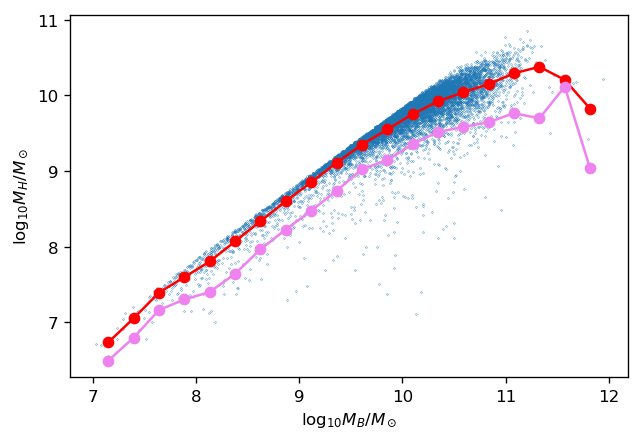

In [5]:
N = 20
stat, bin_edges, __ = binned_statistic(logMB, logMH, bins=N, statistic=np.mean)
statstd, bin_edges, __ = binned_statistic(logMB, logMH, bins=N, statistic=np.std)

bin_centers = p.bin_centers(bin_edges)

lowbound = stat-2*statstd

MB2MHI_func = interp1d(bin_centers, lowbound)



plt.figure(dpi=120)
plt.scatter(logMB, logMH, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, lowbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_B/M_\odot$")
plt.ylabel(r"$\log_{10}M_H /M_\odot$")
plt.show()

In [6]:
def func_absmag(appmag, d):
    # Distance in Mpc
    return appmag-25-5*np.log10(d)

absmag = list()
for i, j in zip(apmag, dist):
    absmag.append(func_absmag(i, j))
absmag = np.array(absmag)

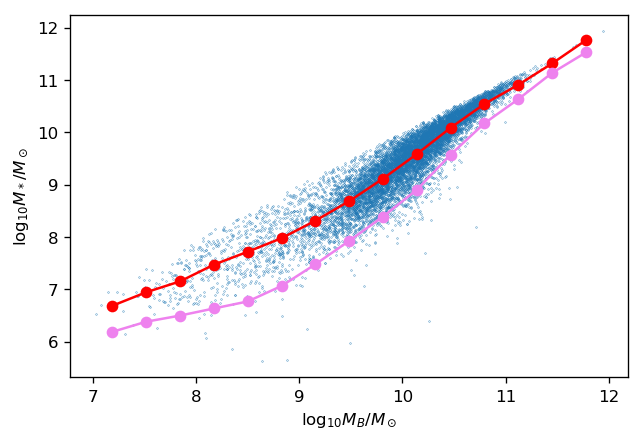

In [7]:
stat, bin_edges, __ = binned_statistic(logMB, logMS, bins=15)
statstd, bin_edges, __ = binned_statistic(logMB, logMS, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

lowerbound = stat-2*statstd

MB2MS_func = interp1d(bin_centers, stat)
# MB2MS_func2 = interp1d(bin_centers, stat)

plt.figure(dpi=120)
plt.scatter(logMB, logMS, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, lowerbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_B/M_\odot$")
plt.ylabel(r"$\log_{10}M_*/M_\odot$")
plt.show()

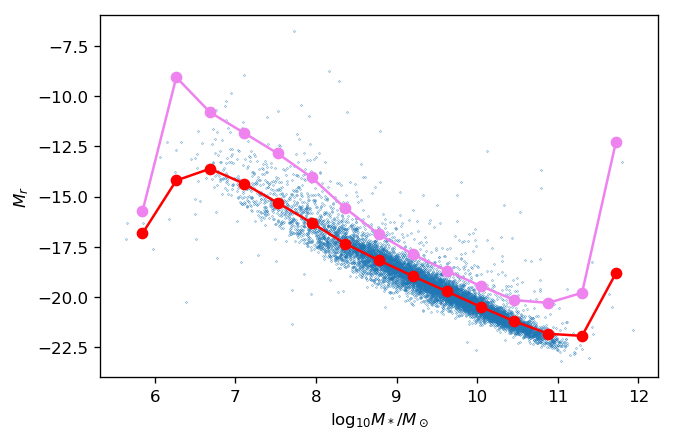

In [8]:
stat, bin_edges, __ = binned_statistic(logMS, absmag, bins=15)
statstd, bin_edges, __ = binned_statistic(logMS, absmag, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

upperbound = stat+2*statstd

MS2absmag_func = interp1d(bin_centers, upperbound)

plt.figure(dpi=120)
plt.scatter(logMS, absmag, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, upperbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$M_r$")
plt.show()

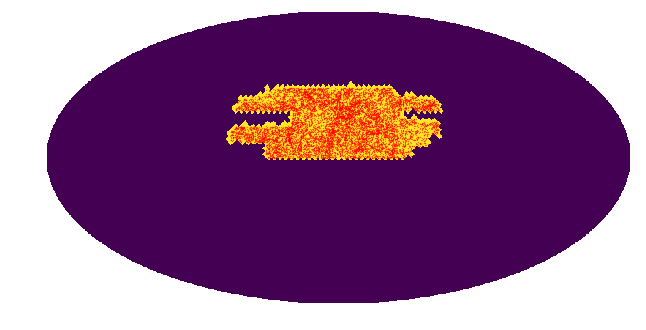

In [9]:
# Get pixel coverage for the random catalog
nside=25
hpmap = np.zeros(hp.nside2npix(nside))
active_pixs = list()
for r, d in zip(np.deg2rad(RA), np.deg2rad(DEC)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    hpmap[pix] = 1
    active_pixs.append(pix)
    
hp.mollview(hpmap, rot=180, cbar=False, title='')
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05, c='red')

active_pixs = np.unique(np.array(active_pixs))

logMBlim 10.044202522198823
logMHIlim 9.308813782103602 logMSlim 9.446527251619603 absmaglim -18.35295777880553


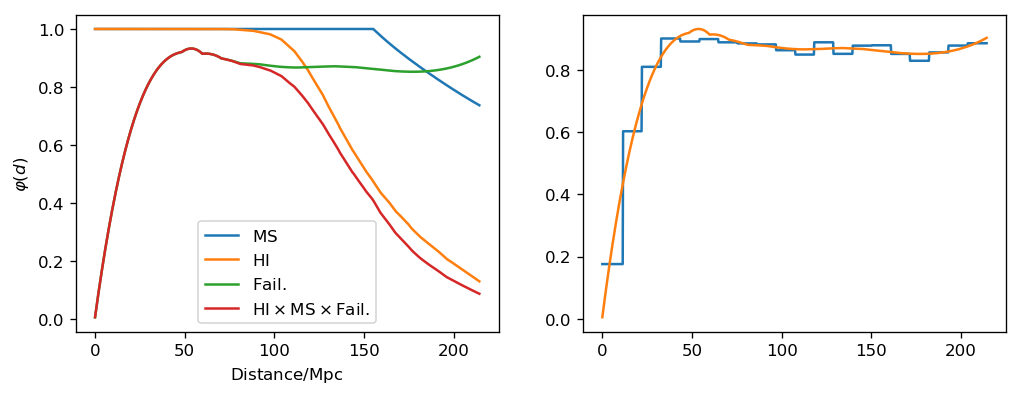

In [23]:
num = 2
logMBlim = cuts[num]
perc = perc_list[num]
print("logMBlim", logMBlim)
logMHlim = MB2MHI_func(logMBlim)
logMSlim = MB2MS_func(logMBlim)
absmaglim = MS2absmag_func(logMSlim)
print("logMHIlim", logMHlim, "logMSlim", logMSlim,"absmaglim", absmaglim)


dist_arr = np.linspace(0.1, dist.max(), 1000)

y1 = SelectionFunc.survival_func_HI(dist_arr, logMHlim, 151)(dist_arr)
y2coarse, y2smooth, y2func = SelectionFunc.survival_rate(dist_arr, logMHlim, logMH.max(), 451, 3)
y2 = y2func(dist_arr)
y3 = SelectionFunc.survival_func_SM(dist_arr, absmaglim)(dist_arr)

y = y1*y2*y3
surv_func = interp1d(dist_arr, y)


plt.figure(dpi=120, figsize=(10,3.5))

plt.subplot(121)
plt.plot(dist_arr, y3, label=r"$\mathrm{MS}$")
plt.plot(dist_arr, y1, label=r"$\mathrm{HI}$")
plt.plot(dist_arr, y2, label=r"$\mathrm{Fail.}$")
plt.plot(dist_arr, y, label=r"$\mathrm{HI}\times\mathrm{MS}\times \mathrm{Fail.}$")
plt.ylabel(r"$\varphi(d)$")
plt.xlabel(r"$\mathrm{Distance}/\mathrm{Mpc}$")
plt.legend()

plt.subplot(122)
plt.plot(dist_arr, y2coarse)
plt.plot(dist_arr, y2smooth)

plt.show()


5553792
2052441


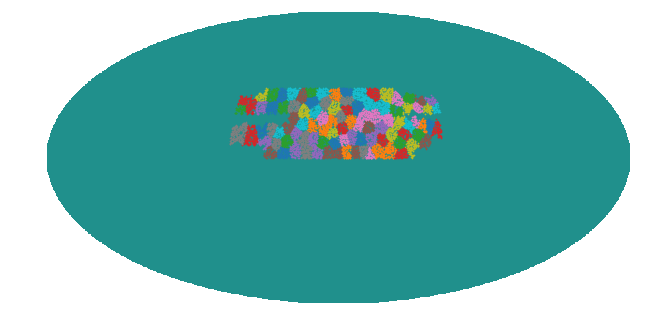

In [24]:
# Generate a random catalog
Nrands = 5e6
Nrands_target = int(Nrands/0.75)
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
Pmin = (np.sin(np.deg2rad(DEC.min()))+1)/2
Pmax = (np.sin(np.deg2rad(DEC.max()))+1)/2
distmin, distmax = dist.min(), dist.max()

randRA = np.random.uniform(RAmin, RAmax, Nrands_target)
randDEC = np.arcsin(2*np.random.uniform(Pmin, Pmax, size=Nrands_target)-1)
randdist = powerlaw.rvs(a=3, loc=distmin, scale=distmax-distmin, size=Nrands_target)

# Eliminate galaxies in pixels not covered by the ALFALFA survey
pixels = hp.ang2pix(nside, np.pi/2-randDEC, randRA)
IDS = np.where(np.isin(pixels, active_pixs)==True)
# Switch to degrees
randRA= np.rad2deg(randRA[IDS])
randDEC = np.rad2deg(randDEC[IDS])
randdist = randdist[IDS]

# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)

hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
for label in np.unique(km.labels):
    IDSlab = np.where(km.labels==label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)
    
# Apply selection effects to the rand.
N = randdist.size
print(N)

prob_surv = surv_func(randdist)
# Don't forget RFI..
hvel = list()
for r, d, distance in zip(np.deg2rad(randRA), np.deg2rad(randDEC), randdist):
    hvel.append(SelectionFunc.heliovelocity([r, d, distance]))
hvel = np.array(hvel)

prob_rfi = SelectionFunc.survival_func_rfi(hvel)
# prob_rfi=1

prob_arr = prob_surv*prob_rfi
rand_arr = np.random.uniform(0, 1, N)

IDS = np.where((prob_arr-rand_arr) > 0)
randdist = randdist[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]
randLabels = randLabels[IDS]
print(randdist.size)

Number density is 0.0047037854676044285


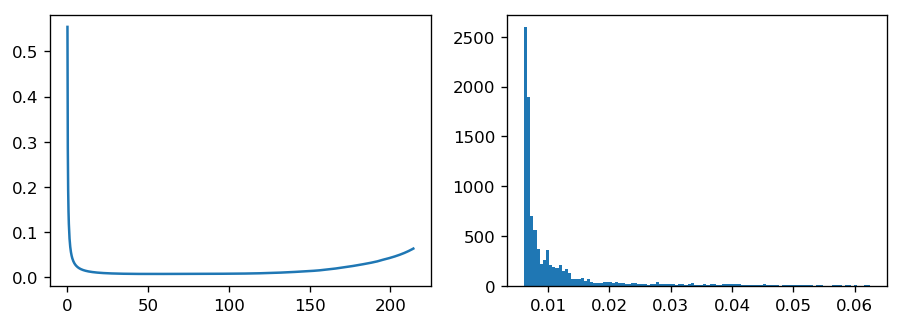

In [25]:
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

number_density = 0
mlow_ind = np.abs(logMHlim-np.array(massbins)).argmin()

for i in range(len(w50bins)-1):
    dw50 = w50bins[i+1]-w50bins[i]
    w50 = (w50bins[i+1]+w50bins[i])/2

    for j in range(mlow_ind, len(massbins)-1):
        dm = massbins[j+1]-massbins[j]
        number_density += MFW[j, i]*dm*dw50

print("Number density is {}".format(number_density))

J3 = 2962

def get_weights(dist):
    return 1/(1+4*np.pi*number_density*J3*surv_func(dist))

plt.figure(dpi=120, figsize=(9,3))

plt.subplot(121)
plt.plot(dist_arr, get_weights(dist_arr))

plt.subplot(122)
plt.hist(get_weights(dist), bins='auto')

plt.show()

N. gal above this mass cut 5179


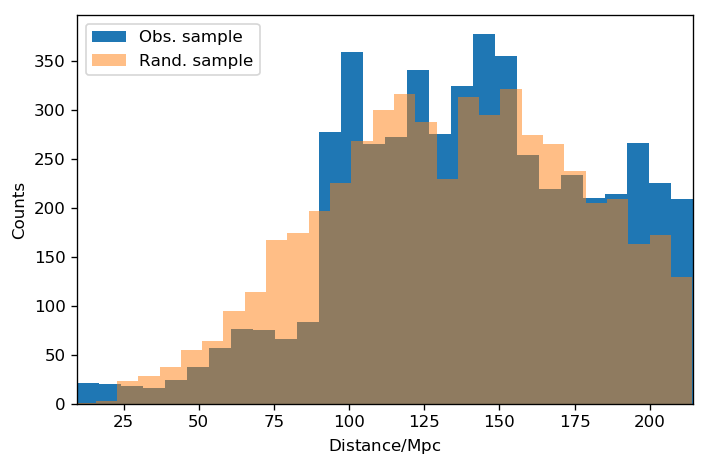

In [26]:
# Plot how do the histograms differ
IDS = np.where(logMB>logMBlim)
print("N. gal above this mass cut", IDS[0].size)


# Downsample randcat to the same size as catalog
IDS2 = np.random.choice(np.arange(randdist.size), dist[IDS].size, replace=False)

# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120)

plt.hist(dist[IDS], bins='auto', label="Obs. sample")
plt.hist(randdist[IDS2], bins='auto', label="Rand. sample", alpha=0.5)
plt.ylabel(r"Counts")
plt.xlabel(r"Distance$/\mathrm{Mpc}$")
plt.xlim(dist[IDS].min(), dist[IDS].max())
plt.legend()
plt.tight_layout()
plt.show()

We have 2052441 galaxies in random.
We have 5179 galaxies in observation.


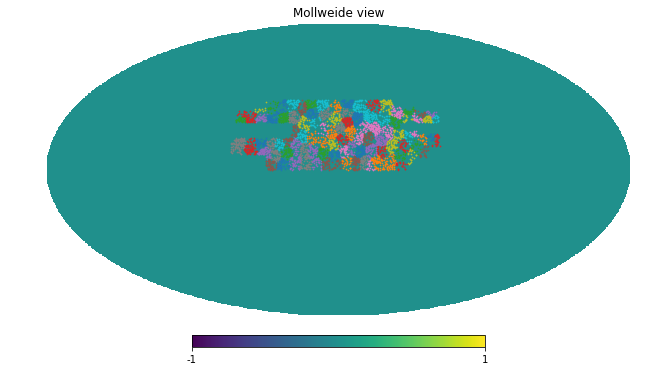

In [27]:
N = randdist.size
random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA
random_catalog['dec'] = randDEC
random_catalog['dist'] = randdist
random_catalog['label'] = randLabels
# random_catalog['weights'] = np.ones_like(randRA)
random_catalog['weights'] = get_weights(randdist)

np.save("../../Data/BMmatching/CFrandcatBM_{}_.npy".format(perc), random_catalog)
print("We have {} galaxies in random.".format(N))

IDS = np.where(logMB>logMBlim)
N = dist[IDS].size
X = np.vstack([RA[IDS], DEC[IDS]]).T

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['dist'] = dist[IDS]
cut_catalog['weights'] = get_weights(dist[IDS])
cut_catalog['label'] = km.find_nearest(X)
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/BMmatching/CFcatBM_{}_.npy".format(perc), cut_catalog)
print("We have {} galaxies in observation.".format(N))

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)

In [29]:
!ls ../../Data/BMmatching/

CFcatBM_0.5_.npy  CFcatBM_0.9_.npy	CFrandcatBM_0.7_.npy  halos_list.npy
CFcatBM_0.7_.npy  CFrandcatBM_0.5_.npy	CFrandcatBM_0.9_.npy  logMBcuts_def.p
